# Fig 3: FWHM vs gain

### Imports and configurations

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sas_pet.fwhm_gain import DetectorRingConfig, FwhmGainConfig, compute_fwhm_gain_tables

In [2]:
MC_ROOT = Path("../results/MC_data_1e7")
Rs = [5.0, 10.0, 15.0]

R_DET_CM = 15.0
RING_LENGTH_CM = 30.0

RPERP_MAX_GLOBAL = 7.0
ZABS_MAX_GLOBAL = 7.0

BIN_WIDTH_R = 0.05
BIN_WIDTH_Z = 0.05

NBINS_R = int(RPERP_MAX_GLOBAL / BIN_WIDTH_R) + 1
NBINS_Z = int(ZABS_MAX_GLOBAL / BIN_WIDTH_Z) + 1

EDGES_R = np.linspace(0.0, RPERP_MAX_GLOBAL, NBINS_R + 1)
EDGES_Z = np.linspace(0.0, ZABS_MAX_GLOBAL, NBINS_Z + 1)

energy_thresholds = np.array([400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510], float)

N_BOOT = 500
Q_LOW, Q_HIGH = 0.005, 0.995

### Compute tables

In [3]:
det = DetectorRingConfig(R_det_cm=R_DET_CM, ring_length_cm=RING_LENGTH_CM)

cfg = FwhmGainConfig(
    edges_r=EDGES_R,
    edges_z=EDGES_Z,
    energy_thresholds_keV=energy_thresholds,
    n_boot=N_BOOT,
    q_low=Q_LOW,
    q_high=Q_HIGH,
    rng_seed=123,
    min_n=30,
)

tbl_by_R = compute_fwhm_gain_tables(
    MC_ROOT,
    Rs,
    det=det,
    cfg=cfg,
)

for R in Rs:
    tbl = tbl_by_R[R]
    print(f"\n--- R={R:.0f} cm ---")
    print(tbl[[
        "Eth_keV","N_extra","Gain_pct",
        "FWHM_perp_cm","FWHM_perp_lo_cm","FWHM_perp_hi_cm",
        "FWHM_z_cm","FWHM_z_lo_cm","FWHM_z_hi_cm","N_unscattered",
    ]].to_string(index=False))


--- R=5 cm ---
 Eth_keV  N_extra  Gain_pct  FWHM_perp_cm  FWHM_perp_lo_cm  FWHM_perp_hi_cm  FWHM_z_cm  FWHM_z_lo_cm  FWHM_z_hi_cm  N_unscattered
   510.0    12166  0.669870      0.136668         0.133627         0.140023   0.119436      0.117870      0.121165        1816173
   500.0    86243  4.748612      0.311099         0.301925         0.320756   0.165723      0.159154      0.172569        1816173
   490.0   160605  8.843045      0.423423         0.412340         0.435633   0.197155      0.191496      0.202254        1816173
   480.0   234711 12.923383      0.518037         0.504242         0.536685   0.217843      0.213086      0.222771        1816173
   470.0   307899 16.953176      0.616287         0.600572         0.640393   0.232685      0.227391      0.237603        1816173
   460.0   381098 20.983574      0.693633         0.679442         0.707498   0.246358      0.241105      0.253223        1816173
   450.0   453620 24.976696      0.759197         0.740260         0.77831

### Visualize

In [4]:
COLUMNWIDTH_PT = 242.5389
INCH_PER_PT = 1 / 72.27
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT

FIG_W_WIDE = FIG_W * 2.25
FIG_H_WIDE = FIG_W * 0.90

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.alpha": 0.5,
    "grid.color": "white",
    "axes.facecolor": "whitesmoke",
})

In [5]:
CMAP = plt.cm.inferno
CMAP_MIN, CMAP_MAX = 0.2, 0.85
eth_colors = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, len(energy_thresholds)))
eth_to_idx = {float(E): j for j, E in enumerate(energy_thresholds)}

### $\mathrm{FWHM}_\perp$

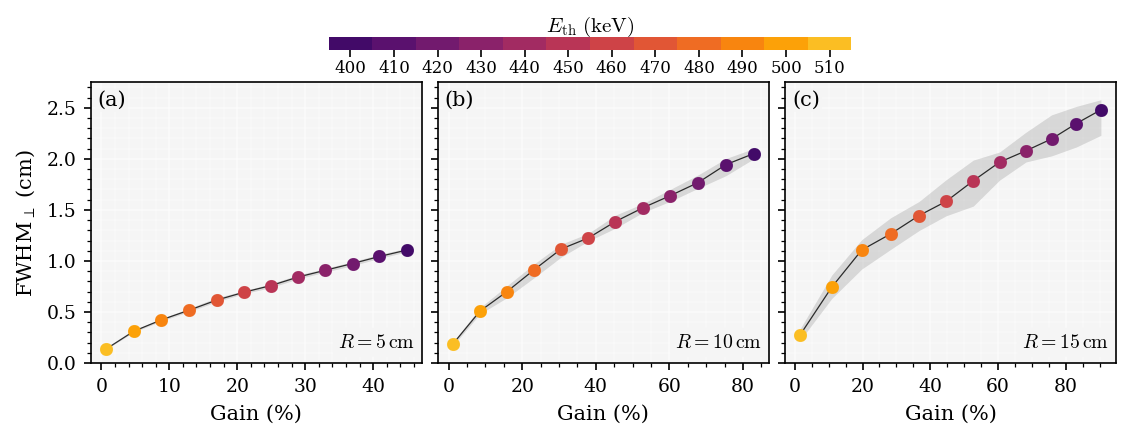

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_W_WIDE, FIG_H_WIDE), sharex=False, sharey=False)
fig.subplots_adjust(left=0.08, right=0.985, bottom=0.18, top=0.80, wspace=0.05)

panel_tags = ["(a)", "(b)", "(c)"]
y_min = 0.0
y_max = 2.75

for i, R_obj in enumerate(Rs):
    ax = axes[i]
    tbl = tbl_by_R[R_obj]

    x = tbl["Gain_pct"].to_numpy(float)
    y = tbl["FWHM_perp_cm"].to_numpy(float)
    lo = tbl["FWHM_perp_lo_cm"].to_numpy(float)
    hi = tbl["FWHM_perp_hi_cm"].to_numpy(float)
    eths = tbl["Eth_keV"].to_numpy(float)

    order = np.argsort(x)
    x2, y2, lo2, hi2, eths2 = x[order], y[order], lo[order], hi[order], eths[order]

    ok = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(lo2) & np.isfinite(hi2)
    x2, y2, lo2, hi2, eths2 = x2[ok], y2[ok], lo2[ok], hi2[ok], eths2[ok]

    ax.fill_between(x2, lo2, hi2, color="black", alpha=0.12, linewidth=0, zorder=1)
    ax.plot(x2, y2, "-", color="black", linewidth=0.6, zorder=2, alpha=0.8)

    for xx, yy, Eth in zip(x2, y2, eths2):
        j = eth_to_idx.get(float(Eth), None)
        col = eth_colors[j] if j is not None else "black"
        ax.scatter(xx, yy, s=38, color=col, edgecolor=None, linewidth=0.1, zorder=7)

    if i == 0:
        ax.set_ylabel(r"FWHM$_\perp$ (cm)")
    ax.set_xlabel("Gain (%)")

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))

    ax.text(
        0.02, 0.97, panel_tags[i],
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0),
        zorder=10,
    )

    ax.text(
        0.98, 0.04, rf"$R={R_obj:.0f}\,\mathrm{{cm}}$",
        transform=ax.transAxes, ha="right", va="bottom", fontsize=9.5,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    ax.set_ylim(y_min, y_max)
    if i > 0:
        ax.tick_params(labelleft=False)

N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(eth_colors), norm=norm)
sm.set_array([])

pos0 = axes[1].get_position()
pos2 = axes[1].get_position()
cax = fig.add_axes([pos0.x0 * 0.75, pos0.y1 + 0.07, pos2.x1 * 1.25 - pos0.x0, 0.03])

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=np.arange(N) + 0.5, drawedges=False)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}~\mathrm{(keV)}$", fontsize=10, labelpad=2.5)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=8, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)


out_dir = Path("../results/figures/gain_vs_fwhm/")
fwhm_gain_perp_dir = Path(out_dir / "fwhm_perp")
out_dir.mkdir(parents=True, exist_ok=True)
fwhm_gain_perp_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "fwhm_perp" / "fwhm_perp_vs_gain_all.pdf", bbox_inches="tight", pad_inches=0.02)
fig.savefig(out_dir / "fwhm_perp" / "fwhm_perp_vs_gain_all.svg", bbox_inches="tight", pad_inches=0.02)

plt.show()

In [10]:
for i, R_obj in enumerate(Rs):
    fig1, ax = plt.subplots(figsize=(FIG_W, FIG_W * 0.85))
    tbl = tbl_by_R[R_obj]

    x = tbl["Gain_pct"].to_numpy(float)
    y = tbl["FWHM_perp_cm"].to_numpy(float)
    lo = tbl["FWHM_perp_lo_cm"].to_numpy(float)
    hi = tbl["FWHM_perp_hi_cm"].to_numpy(float)
    eths = tbl["Eth_keV"].to_numpy(float)

    order = np.argsort(x)
    x2, y2, lo2, hi2, eths2 = x[order], y[order], lo[order], hi[order], eths[order]
    ok = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(lo2) & np.isfinite(hi2)
    x2, y2, lo2, hi2, eths2 = x2[ok], y2[ok], lo2[ok], hi2[ok], eths2[ok]

    ax.fill_between(x2, lo2, hi2, color="black", alpha=0.12, linewidth=0)
    ax.plot(x2, y2, "-", color="black", linewidth=0.8, alpha=0.85)

    for xx, yy, Eth in zip(x2, y2, eths2):
        j = eth_to_idx.get(float(Eth), None)
        col = eth_colors[j] if j is not None else "black"
        ax.scatter(xx, yy, s=40, color=col, edgecolor=None, linewidth=0.1)

    ax.set_xlabel("Gain (%)")
    ax.set_ylabel(r"FWHM$_\perp$ (cm)")
    ax.set_ylim(0.0, 2.75)

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.text(
        0.98, 0.04, rf"$R={R_obj:.0f}\,\mathrm{{cm}}$",
        transform=ax.transAxes, ha="right", va="bottom", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    fig1.savefig(out_dir / "fwhm_perp" / f"fwhm_perp_vs_gain_R{int(R_obj)}.pdf", bbox_inches="tight", pad_inches=0.02, transparent = False, dpi = 300)
    fig1.savefig(out_dir / "fwhm_perp" / f"fwhm_perp_vs_gain_R{int(R_obj)}.svg", bbox_inches="tight", pad_inches=0.02,transparent= False, dpi = 300)
    plt.close(fig1)

### $\mathrm{FWHM}_\parallel$

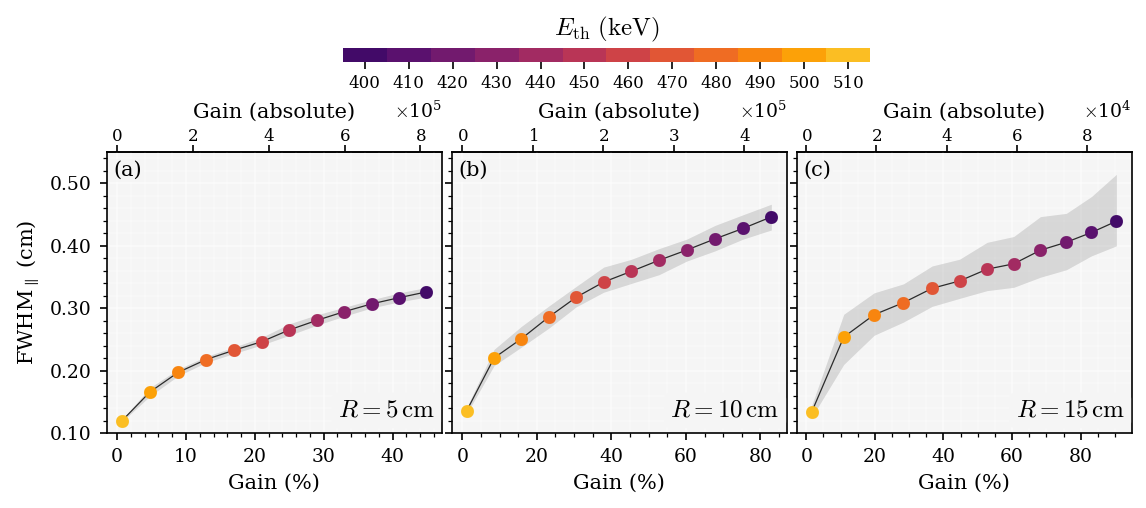

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_W_WIDE, FIG_H_WIDE), sharex=False, sharey=False)
fig.subplots_adjust(left=0.08, right=0.985, bottom=0.18, top=0.80, wspace=0.03)

panel_tags = ["(a)", "(b)", "(c)"]
y_min = 0.1
y_max = 0.55

for i, R_obj in enumerate(Rs):
    ax = axes[i]
    tbl = tbl_by_R[R_obj]

    x = tbl["Gain_pct"].to_numpy(float)
    y = tbl["FWHM_z_cm"].to_numpy(float)
    lo = tbl["FWHM_z_lo_cm"].to_numpy(float)
    hi = tbl["FWHM_z_hi_cm"].to_numpy(float)
    eths = tbl["Eth_keV"].to_numpy(float)

    order = np.argsort(x)
    x2, y2, lo2, hi2, eths2 = x[order], y[order], lo[order], hi[order], eths[order]
    ok = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(lo2) & np.isfinite(hi2)
    x2, y2, lo2, hi2, eths2 = x2[ok], y2[ok], lo2[ok], hi2[ok], eths2[ok]

    ax.fill_between(x2, lo2, hi2, color="black", alpha=0.12, linewidth=0, zorder=1)
    ax.plot(x2, y2, "-", color="black", linewidth=0.6, zorder=2, alpha=0.8)

    for xx, yy, Eth in zip(x2, y2, eths2):
        j = eth_to_idx.get(float(Eth), None)
        col = eth_colors[j] if j is not None else "black"
        ax.scatter(xx, yy, s=38, color=col, edgecolor=None, linewidth=0.1, zorder=7)

    if i == 0:
        ax.set_ylabel(r"FWHM$_\parallel$ (cm)")
    ax.set_xlabel("Gain (%)")

    N0 = float(tbl["N_unscattered"].iloc[0])
    def pct_to_abs(pct, N0=N0):
        return (np.asarray(pct, float) / 100.0) * N0
    def abs_to_pct(nabs, N0=N0):
        return (np.asarray(nabs, float) / N0) * 100.0

    secax = ax.secondary_xaxis("top", functions=(pct_to_abs, abs_to_pct))
    secax.set_xlabel("Gain (absolute)", labelpad=5)
    secax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    secax.xaxis.get_major_formatter().set_scientific(True)
    secax.xaxis.get_major_formatter().set_powerlimits((0, 0))
    secax.tick_params(axis="x", labelsize=8, pad=0.0)

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

    ax.text(
        0.02, 0.97, panel_tags[i],
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0),
        zorder=10,
    )

    ax.text(
        0.98, 0.04, rf"$R={R_obj:.0f}\,\mathrm{{cm}}$",
        transform=ax.transAxes, ha="right", va="bottom", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    ax.set_ylim(y_min, y_max)
    if i > 0:
        ax.tick_params(labelleft=False)

N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(eth_colors), norm=norm)
sm.set_array([])

pos0 = axes[1].get_position()
pos2 = axes[1].get_position()
cax = fig.add_axes([pos0.x0 * 0.75, pos0.y1 + 0.20, pos2.x1 * 1.25 - pos0.x0, 0.03])

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=np.arange(N) + 0.5, drawedges=False)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}~\mathrm{(keV)}$", fontsize=12, labelpad=6)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=8, pad=3)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)

fwhm_gain_parallel_dir = Path(out_dir / "fwhm_parallel")
fwhm_gain_parallel_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "fwhm_parallel" / "fwhm_z_vs_gain_all.pdf", bbox_inches="tight", pad_inches=0.02)
fig.savefig(out_dir / "fwhm_parallel" / "fwhm_z_vs_gain_all.svg", bbox_inches="tight", pad_inches=0.02)

plt.show()

In [12]:
for i, R_obj in enumerate(Rs):
    fig1, ax = plt.subplots(figsize=(FIG_W, FIG_W * 0.85))
    tbl = tbl_by_R[R_obj]

    x = tbl["Gain_pct"].to_numpy(float)
    y = tbl["FWHM_perp_cm"].to_numpy(float)
    lo = tbl["FWHM_perp_lo_cm"].to_numpy(float)
    hi = tbl["FWHM_perp_hi_cm"].to_numpy(float)
    eths = tbl["Eth_keV"].to_numpy(float)

    order = np.argsort(x)
    x2, y2, lo2, hi2, eths2 = x[order], y[order], lo[order], hi[order], eths[order]
    ok = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(lo2) & np.isfinite(hi2)
    x2, y2, lo2, hi2, eths2 = x2[ok], y2[ok], lo2[ok], hi2[ok], eths2[ok]

    ax.fill_between(x2, lo2, hi2, color="black", alpha=0.12, linewidth=0)
    ax.plot(x2, y2, "-", color="black", linewidth=0.8, alpha=0.85)

    for xx, yy, Eth in zip(x2, y2, eths2):
        j = eth_to_idx.get(float(Eth), None)
        col = eth_colors[j] if j is not None else "black"
        ax.scatter(xx, yy, s=40, color=col, edgecolor=None, linewidth=0.1)

    ax.set_xlabel("Gain (%)")
    ax.set_ylabel(r"FWHM$_\perp$ (cm)")
    ax.set_ylim(0.0, 2.75)

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.text(
        0.98, 0.04, rf"$R={R_obj:.0f}\,\mathrm{{cm}}$",
        transform=ax.transAxes, ha="right", va="bottom", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    fig1.savefig(out_dir / "fwhm_parallel" / f"fwhm_parallel_vs_gain_R{int(R_obj)}.pdf", bbox_inches="tight", pad_inches=0.02, transparent = False, dpi = 300)
    fig1.savefig(out_dir / "fwhm_parallel" / f"fwhm_parallel_vs_gain_R{int(R_obj)}.svg", bbox_inches="tight", pad_inches=0.02,transparent= False, dpi = 300)
    plt.close(fig1)

### Fig 5: Combined plot

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.alpha": 0.5,
    "grid.color": "white",
    "axes.facecolor": "whitesmoke",
})

line_colors = {5: "#3182bd", 10: "#e6550d", 15: "#31a354"}
marker_styles = {5: "o", 10: "s", 15: "^"}

### Utilities

In [14]:
def plot_panel(ax, xcol, ycol, locol, hicol, xlabel, ylabel, yfmt, sci_x=False):
    for R in sorted(tbl_by_R.keys(), key=float):
        tbl = tbl_by_R[R]
        R_key = int(round(float(R)))
        col = line_colors.get(R_key, "black")
        mkr = marker_styles.get(R_key, "o")

        x = tbl[xcol].to_numpy(float)
        y = tbl[ycol].to_numpy(float)
        lo = tbl[locol].to_numpy(float)
        hi = tbl[hicol].to_numpy(float)

        order = np.argsort(x)
        x2, y2, lo2, hi2 = x[order], y[order], lo[order], hi[order]

        ok = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(lo2) & np.isfinite(hi2)
        x2, y2, lo2, hi2 = x2[ok], y2[ok], lo2[ok], hi2[ok]
        if x2.size == 0:
            continue

        ax.fill_between(x2, lo2, hi2, color=col, alpha=0.14, linewidth=0, zorder=1)
        ax.plot(x2, y2, "-", color=col, linewidth=1.6, zorder=2)
        ax.scatter(
            x2, y2,
            s=26, color=col, edgecolor="whitesmoke", linewidth=0.6,
            marker=mkr, zorder=3, label=rf"${R_key}\,\mathrm{{cm}}$"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter(yfmt))
    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.8)

    if sci_x:
        sf = mticker.ScalarFormatter(useMathText=True)
        sf.set_scientific(True)
        sf.set_powerlimits((0, 0))
        ax.xaxis.set_major_formatter(sf)

        ax.figure.canvas.draw()
        oom = ax.xaxis.get_major_formatter().orderOfMagnitude
        ax.xaxis.offsetText.set_visible(False)
        scale = (10.0 ** oom) if oom != 0 else 1.0
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos, s=scale: f"{(v/s):.1f}"))
        if oom != 0:
            ax.text(
                0.98, 0.06, rf"$\times 10^{{{oom}}}$",
                transform=ax.transAxes, ha="right", va="bottom",
                fontsize=10, alpha=0.95
            )

def add_panel_label(ax, label):
    ax.text(
        0.02, 0.98, label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.85, pad=1.5),
        zorder=20,
    )

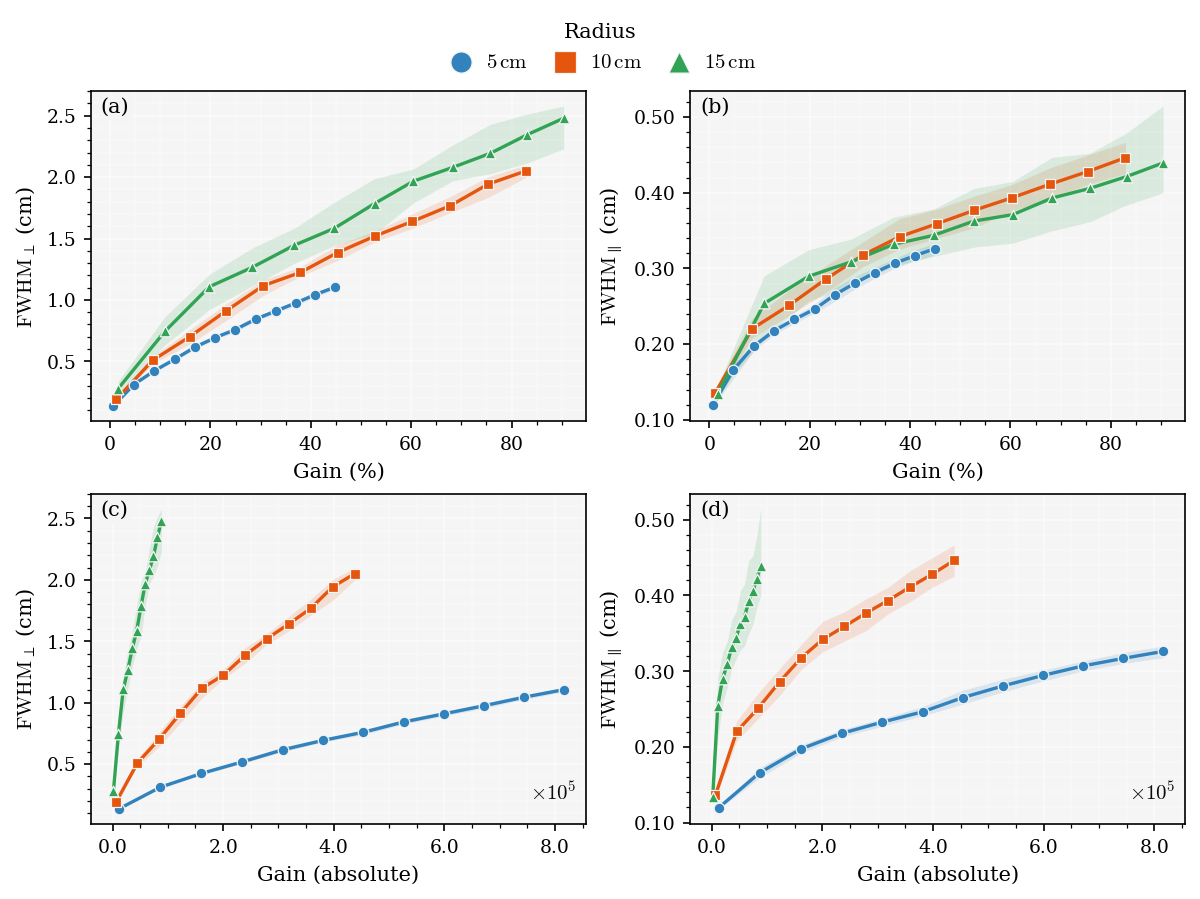

In [21]:


fig, axs = plt.subplots(
    2, 2,
    figsize=(FIG_W * 2.35, FIG_W * 1.60),
    constrained_layout=True,
)

plot_panel(
    axs[0, 0],
    xcol="Gain_pct", ycol="FWHM_perp_cm",
    locol="FWHM_perp_lo_cm", hicol="FWHM_perp_hi_cm",
    xlabel="Gain (%)",
    ylabel=r"$\mathrm{FWHM}_{\perp}$ (cm)",
    yfmt="%.1f",
    sci_x=False,
)

plot_panel(
    axs[0, 1],
    xcol="Gain_pct", ycol="FWHM_z_cm",
    locol="FWHM_z_lo_cm", hicol="FWHM_z_hi_cm",
    xlabel="Gain (%)",
    ylabel=r"$\mathrm{FWHM}_{\parallel}$ (cm)",
    yfmt="%.2f",
    sci_x=False,
)

plot_panel(
    axs[1, 0],
    xcol="N_extra", ycol="FWHM_perp_cm",
    locol="FWHM_perp_lo_cm", hicol="FWHM_perp_hi_cm",
    xlabel="Gain (absolute)",
    ylabel=r"$\mathrm{FWHM}_{\perp}$ (cm)",
    yfmt="%.1f",
    sci_x=True,
)

plot_panel(
    axs[1, 1],
    xcol="N_extra", ycol="FWHM_z_cm",
    locol="FWHM_z_lo_cm", hicol="FWHM_z_hi_cm",
    xlabel="Gain (absolute)",
    ylabel=r"$\mathrm{FWHM}_{\parallel}$ (cm)",
    yfmt="%.2f",
    sci_x=True,
)

add_panel_label(axs[0, 0], "(a)")
add_panel_label(axs[0, 1], "(b)")
add_panel_label(axs[1, 0], "(c)")
add_panel_label(axs[1, 1], "(d)")

handles, labels = axs[0, 0].get_legend_handles_labels()
leg = fig.legend(
    handles, labels,
    title="Radius",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=3,
    frameon=False,
    fontsize=10,
    title_fontsize=10,
    markerscale=2.0,
    handlelength=1.6,
    handletextpad=0.4,
    columnspacing=1.0,
    borderpad=0.4,
)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("whitesmoke")
leg.get_frame().set_alpha(0.95)

plt.show()

summary_dir = Path(out_dir / "summary")
summary_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(summary_dir / "summary_2_by_2.pdf", bbox_inches="tight", pad_inches=0.02, transparent=False)
fig.savefig(summary_dir / "summary_2_by_2.svg", bbox_inches="tight", pad_inches=0.02, transparent=False)

In [24]:
def make_single_panel(
    *,
    panel_tag: str,
    xcol: str,
    ycol: str,
    locol: str,
    hicol: str,
    xlabel: str,
    ylabel: str,
    yfmt: str,
    sci_x: bool,
    out_base: str,
    figsize=(None, None),
):
    w = FIG_W * 1.25 if figsize[0] is None else figsize[0]
    h = FIG_W * 0.95 if figsize[1] is None else figsize[1]

    fig1, ax1 = plt.subplots(figsize=(w, h))
    fig1.subplots_adjust(left=0.12, right=0.98, bottom=0.12, top=0.97)

    plot_panel(
        ax1,
        xcol=xcol, ycol=ycol,
        locol=locol, hicol=hicol,
        xlabel=xlabel, ylabel=ylabel,
        yfmt=yfmt, sci_x=sci_x,
    )

    add_panel_label(ax1, panel_tag)

    handles, labels = ax1.get_legend_handles_labels()
    leg = ax1.legend(
        handles, labels,
        title="Radius",
        loc="best",
        frameon=True,
    )
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("whitesmoke")
    leg.get_frame().set_alpha(0.95)

    for sp in ("top", "right"):
        ax1.spines[sp].set_visible(False)

    plt.show()

    fig1.savefig(out_base + ".pdf", bbox_inches="tight", pad_inches=0.02, transparent=False, dpi = 300)
    fig1.savefig(out_base + ".svg", bbox_inches="tight", pad_inches=0.02, transparent=False, dpi = 300)
    plt.close(fig1)

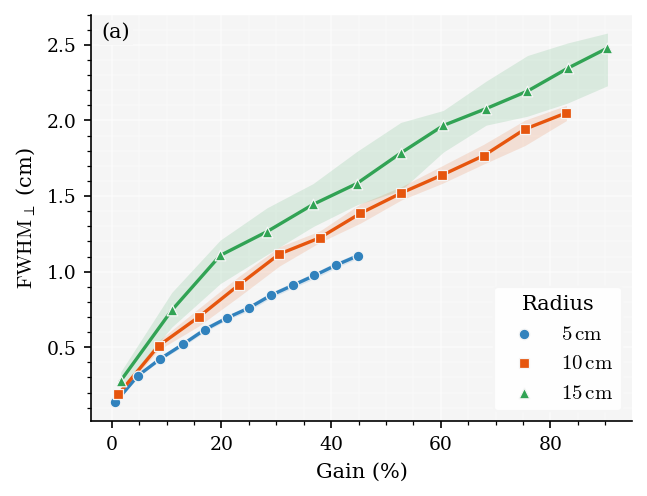

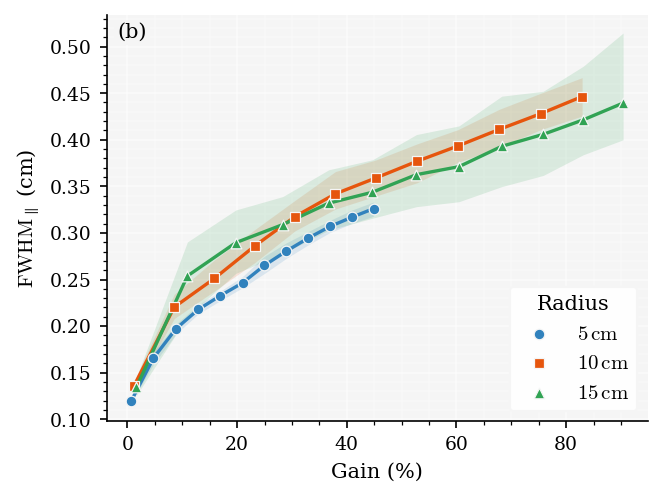

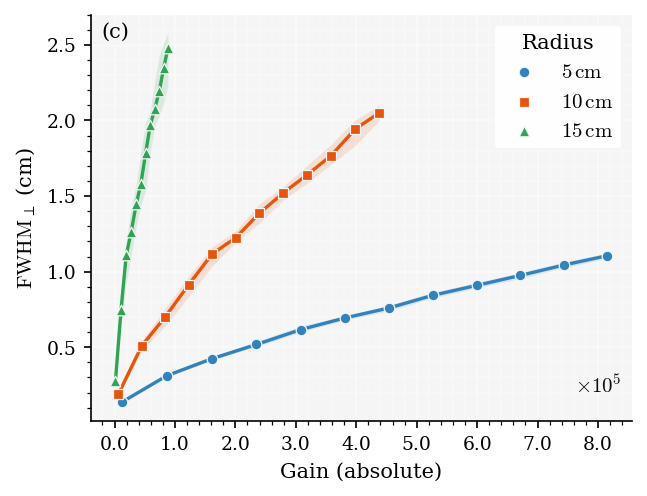

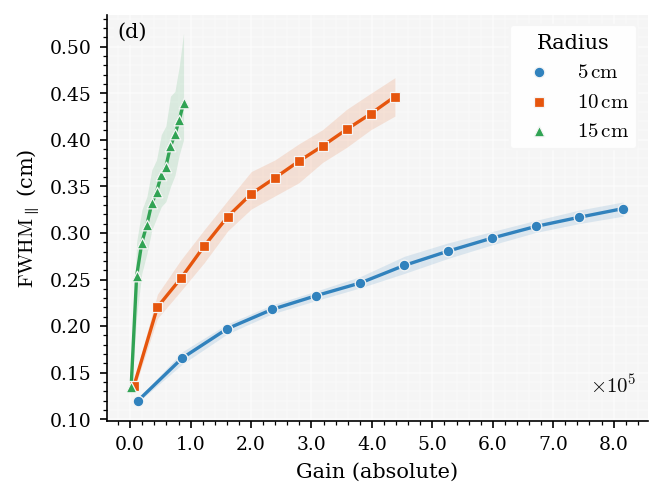

In [25]:
base = "../results/figures/gain_vs_fwhm/summary"

make_single_panel(
    panel_tag="(a)",
    xcol="Gain_pct", ycol="FWHM_perp_cm",
    locol="FWHM_perp_lo_cm", hicol="FWHM_perp_hi_cm",
    xlabel="Gain (%)",
    ylabel=r"$\mathrm{FWHM}_{\perp}$ (cm)",
    yfmt="%.1f",
    sci_x=False,
    out_base=f"{base}/summary_a",
)

make_single_panel(
    panel_tag="(b)",
    xcol="Gain_pct", ycol="FWHM_z_cm",
    locol="FWHM_z_lo_cm", hicol="FWHM_z_hi_cm",
    xlabel="Gain (%)",
    ylabel=r"$\mathrm{FWHM}_{\parallel}$ (cm)",
    yfmt="%.2f",
    sci_x=False,
    out_base=f"{base}/summary_b",
)

make_single_panel(
    panel_tag="(c)",
    xcol="N_extra", ycol="FWHM_perp_cm",
    locol="FWHM_perp_lo_cm", hicol="FWHM_perp_hi_cm",
    xlabel="Gain (absolute)",
    ylabel=r"$\mathrm{FWHM}_{\perp}$ (cm)",
    yfmt="%.1f",
    sci_x=True,
    out_base=f"{base}/summary_c",
)

make_single_panel(
    panel_tag="(d)",
    xcol="N_extra", ycol="FWHM_z_cm",
    locol="FWHM_z_lo_cm", hicol="FWHM_z_hi_cm",
    xlabel="Gain (absolute)",
    ylabel=r"$\mathrm{FWHM}_{\parallel}$ (cm)",
    yfmt="%.2f",
    sci_x=True,
    out_base=f"{base}/summary_d",
)